---
title: Calculating the Ratio of Horizontal to Vertical Details in a Text Image
date: "2024-08-28"
author: Vishal Bakshi
description: In this blog post I use the PyWavelets library to calculate the ratio of horizontal to vertical details in text image.
filters:
   - lightbox
lightbox: auto
categories:
    - python
    - computer vision
    - TypefaceClassifier
---

## Background

In this notebook, I'll walk through an algorithm suggested by Claude to calculate the ratio of horizontal to vertical features in a text image.

I planned to implement a serif detection algorithm but didn't get good results from the 8-9 algorithms Claude suggested. This horizontal-to-vertical feature ratio algorithm emerged from brainstorming with Claude as an alternative approach.

As we'll see, serifs tend to introduce more horizontal features, especially at the base of letters.

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I’ll train a neural network for this task. This is one of many notebooks in my [**TypefaceClassifier** project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

## Using PyWavelets to Detect Horizontal/Vertical Features

This algorithm is quite concise (compared to some of the [other ones I've done](https://vishalbakshi.github.io/blog/index.html#category=TypefaceClassifier)).

We start by loading the image in grayscale.

In [26]:
#| code-fold: true
#| code-summary: "Show imports"
!pip install PyWavelets -qq
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
path = 'serif-76px.png'

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
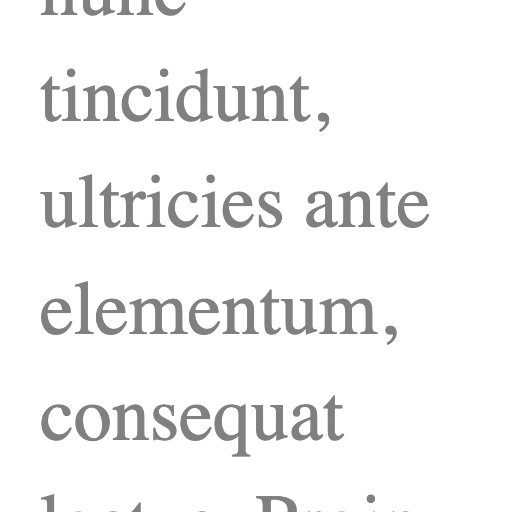

In [5]:
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img

We then pass the image to `pywt.dwt2` which according to the docs is a "2D Forward and Inverse Discrete Wavelet Transform" and returns "Approximation, horizontal detail, vertical detail and diagonal detail coefficients".

A couple of definitions (from Wikipedia):

> **wavelet**: A wavelet is a wave-like oscillation with an amplitude that begins at zero, increases or decreases, and then returns to zero one or more times. Wavelets are termed a "brief oscillation". A taxonomy of wavelets has been established, based on the number and direction of its pulses. Wavelets are imbued with specific properties that make them useful for signal processing.

> **Haar wavelet**: In mathematics, the Haar wavelet is a sequence of rescaled "square-shaped" functions which together form a wavelet family or basis.

A bit more context from Claude:

> For images, we use a 2D version of the DWT.
It applies the transform first to the rows and then to the columns of the image.
This results in four subbands: approximation (LL), horizontal detail (LH), vertical detail (HL), and diagonal detail (HH).

> The Haar wavelet is the simplest type of wavelet.
It looks like a step function and is good at capturing abrupt transitions in the signal.
In the context of images, it's effective at detecting edges and sudden changes in intensity.

So it seems like the step-function behavior of the Haar wavelet is useful in finding horizontal and vertical edges and changes in intensity.

In [8]:
cA, (cH, cV, cD) = pywt.dwt2(img, 'haar')
cA.shape, cH.shape, cV.shape, cD.shape

((256, 256), (256, 256), (256, 256), (256, 256))

We calculate the "energy" of horizontal and vertical details, where "energy" = sum of the absolute values of the details.

In [9]:
h_energy = np.sum(np.abs(cH))
v_energy = np.sum(np.abs(cV))
h_energy, v_energy

(143034.5, 169463.5)

Finally, we calculate the ratio of the horizontal to vertical energy:

In [10]:
ratio = h_energy / (v_energy + 1e-5)
ratio

0.8440431124788499

## Visualizing Horizontal and Vertical Details

I'll wrap the above functionality, plus visualization code provided by Claude, to visualize the vertical and horizontal features of an image:

In [15]:
#| code-fold: true
#| code-summary: "Show `visualize_dwt2` function"
def visualize_dwt2(path):
    # Read the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Apply wavelet transform
    coeffs = pywt.dwt2(img, 'haar')
    _, (cH, cV, _) = coeffs

    # Calculate energy of horizontal and vertical details
    h_energy = np.sum(np.abs(cH))
    v_energy = np.sum(np.abs(cV))

    # Calculate ratio
    ratio = h_energy / (v_energy + 1e-5)

    # Visualize the results
    plt.figure(figsize=(15, 10))

    plt.subplot(221)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(222)
    plt.imshow(cH, cmap='gray')
    plt.title('Horizontal Details')
    plt.axis('off')

    plt.subplot(223)
    plt.imshow(cV, cmap='gray')
    plt.title('Vertical Details')
    plt.axis('off')

    plt.subplot(224)
    energy_data = [h_energy, v_energy]
    plt.bar(['Horizontal', 'Vertical'], energy_data)
    plt.title('Energy Distribution')
    plt.ylabel('Energy')

    plt.suptitle(f'Wavelet Transform Analysis\nH/V Ratio: {ratio:.2f}', fontsize=16)

    plt.tight_layout()
    plt.show()

Looking at the baseline of each row of text in the "Horizontal Details" figure you can see how the serifs have a concentration of darker pixels, resulting in a horizontal/vertical ratio of `0.84`.

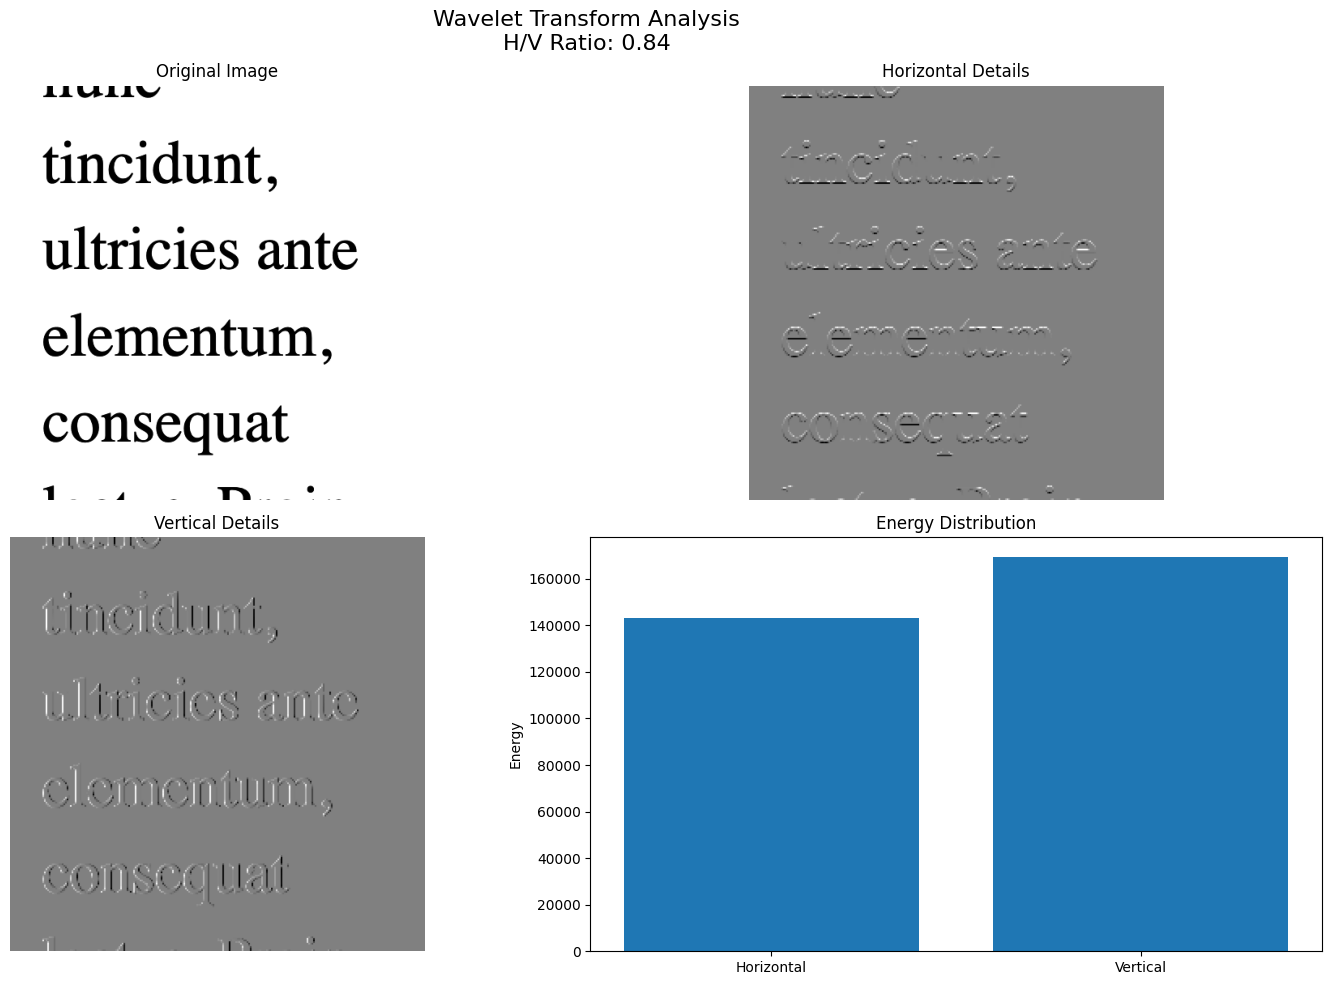

In [16]:
visualize_dwt2('serif-76px.png')

For sans serif text, the baselines contain fewer dark regions in the "Horizontal Details" plot. The horizontal/vertical ratio is considerably lower at `0.62`.

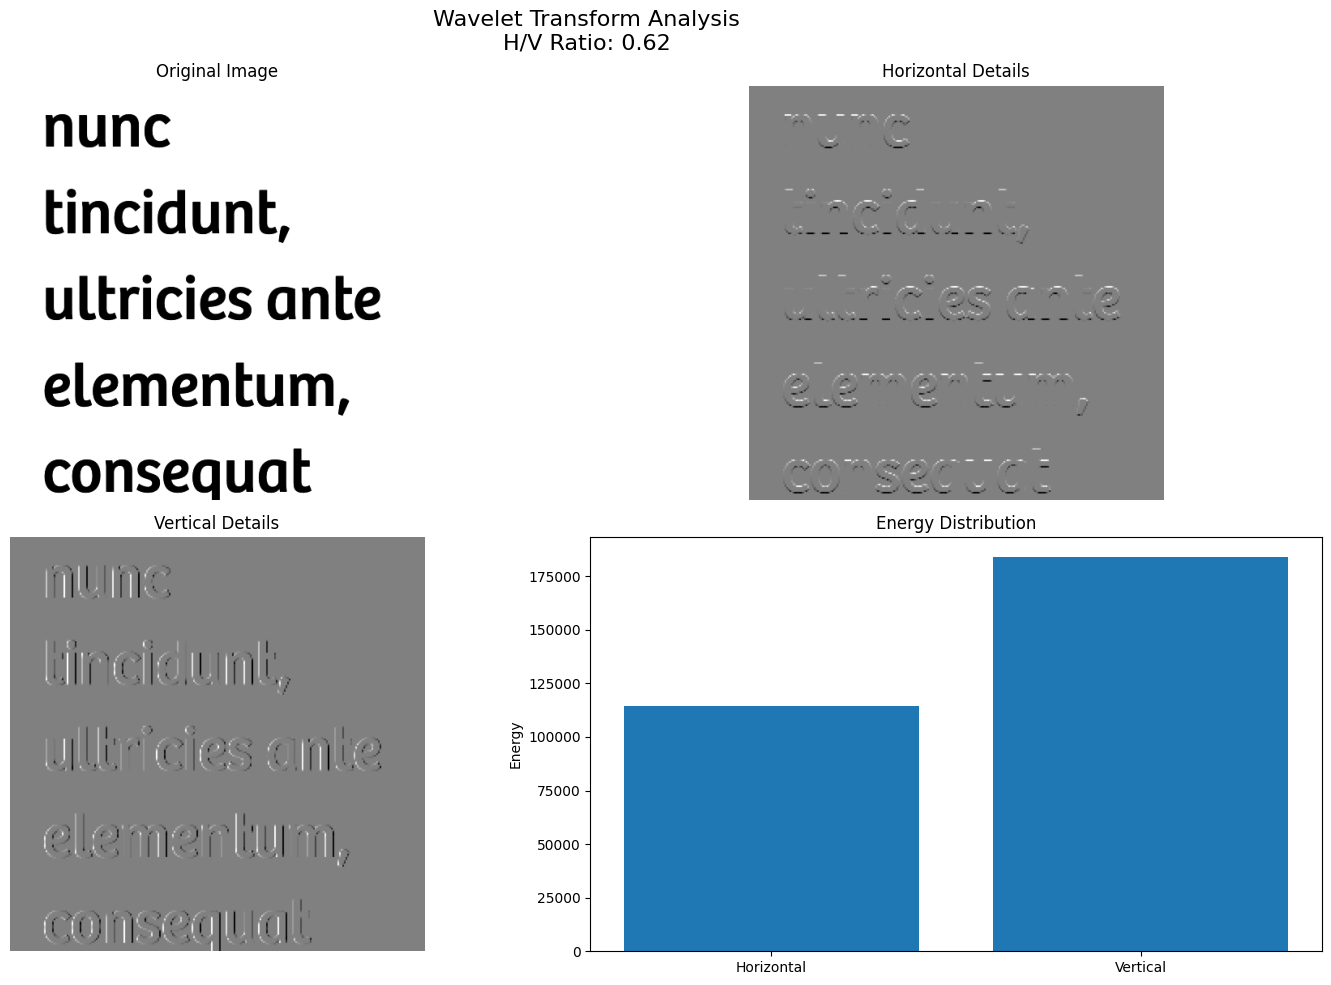

In [17]:
visualize_dwt2('display-76px.png')

## Comparing Horizontal/Vertical Energy Ratio for Different Images

I'll wrap the ratio calculation in a function and calculate it for different text images.

In [19]:
#| code-fold: true
#| code-summary: "Show `hv_ratio` function"
def hv_ratio(path):
    # Read the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Apply wavelet transform
    coeffs = pywt.dwt2(img, 'haar')
    _, (cH, cV, _) = coeffs

    # Calculate energy of horizontal and vertical details
    h_energy = np.sum(np.abs(cH))
    v_energy = np.sum(np.abs(cV))

    # Calculate ratio
    ratio = h_energy / (v_energy + 1e-5)

    return ratio

In [30]:
ts = ['display', 'serif']
szs = [18, 24, 36, 76, 240, 330, 420]
res = []

for t in ts:
  for sz in szs:
    res.append([t, sz, hv_ratio(f"{t}-{sz}px.png")])

In [31]:
res

[['display', 18, 0.5991887037716151],
 ['display', 24, 0.681398182285936],
 ['display', 36, 0.6607329816912426],
 ['display', 76, 0.621916364155822],
 ['display', 240, 0.8254012445421878],
 ['display', 330, 0.5510498236874258],
 ['display', 420, 0.6070406043729197],
 ['serif', 18, 0.8503324244597174],
 ['serif', 24, 0.8057746917458858],
 ['serif', 36, 0.8090403181165737],
 ['serif', 76, 0.8440431124788499],
 ['serif', 240, 0.7480835327709404],
 ['serif', 330, 0.7622218104302562],
 ['serif', 420, 0.9064592756666484]]

On average the horizontal-to-vertical detail ratio is higher for images with serif texts than for images with sans serif text.

In [32]:
res = pd.DataFrame(res, columns=['typeface', 'font-size', 'hv-ratio'])
res.groupby('typeface')['hv-ratio'].agg(['mean', 'median'])

,mean,median
typeface,,
display,0.649533,0.621916
serif,0.817994,0.809040


## Final Thoughts

It was exciting to see such elegant results with a single line of code (`pywt.dwt2`), exhibiting the power of wavelets, a topic that I'm not very familiar with.

The horizontal-to-vertical ratio between serifs and sans serifs is distinguishable, making this algorithm a good candidate for distinguishing between two typefaces.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).